# Forest Covertype

### Data Set Information:

Predicting forest cover type from cartographic variables only (no remotely sensed data). The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types).

Some background information for these four wilderness areas: Neota (area 2) probably has the highest mean elevational value of the 4 wilderness areas. Rawah (area 1) and Comanche Peak (area 3) would have a lower mean elevational value, while Cache la Poudre (area 4) would have the lowest mean elevational value.

As for primary major tree species in these areas, Neota would have spruce/fir (type 1), while Rawah and Comanche Peak would probably have lodgepole pine (type 2) as their primary species, followed by spruce/fir and aspen (type 5). Cache la Poudre would tend to have Ponderosa pine (type 3), Douglas-fir (type 6), and cottonwood/willow (type 4).

The Rawah and Comanche Peak areas would tend to be more typical of the overall dataset than either the Neota or Cache la Poudre, due to their assortment of tree species and range of predictive variable values (elevation, etc.) Cache la Poudre would probably be more unique than the others, due to its relatively low elevation range and species composition.

Source: https://archive.ics.uci.edu/ml/datasets/covertype

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

## Exploratory Data Analysis

4 categorical,
10 numerical,
40 binary and
1 class variable with distinct classes

In [12]:
# Column names extracted from the dataset description file
columns = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", 
         "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", 
         "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", 
         "Horizontal_Distance_To_Fire_Points", "Rawah", "Neota", "Comanche Peak", "Cache la Poudre"] + \
       ["Soil_Type {}".format(i) for i in range(40)] + ["Cover_Type"]

In [15]:
data = pd.read_csv('dataset/covtype.data', header=None, names=columns)
data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type 31,Soil_Type 32,Soil_Type 33,Soil_Type 34,Soil_Type 35,Soil_Type 36,Soil_Type 37,Soil_Type 38,Soil_Type 39,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [16]:
data.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type 31,Soil_Type 32,Soil_Type 33,Soil_Type 34,Soil_Type 35,Soil_Type 36,Soil_Type 37,Soil_Type 38,Soil_Type 39,Cover_Type
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
Elevation                             581012 non-null int64
Aspect                                581012 non-null int64
Slope                                 581012 non-null int64
Horizontal_Distance_To_Hydrology      581012 non-null int64
Vertical_Distance_To_Hydrology        581012 non-null int64
Horizontal_Distance_To_Roadways       581012 non-null int64
Hillshade_9am                         581012 non-null int64
Hillshade_Noon                        581012 non-null int64
Hillshade_3pm                         581012 non-null int64
Horizontal_Distance_To_Fire_Points    581012 non-null int64
Rawah                                 581012 non-null int64
Neota                                 581012 non-null int64
Comanche Peak                         581012 non-null int64
Cache la Poudre                       581012 non-null int64
Soil_Type 0                           581012 non-

There are no missing values and datatypes are also in desireable format. Let's investigate distributions of numerical variables.

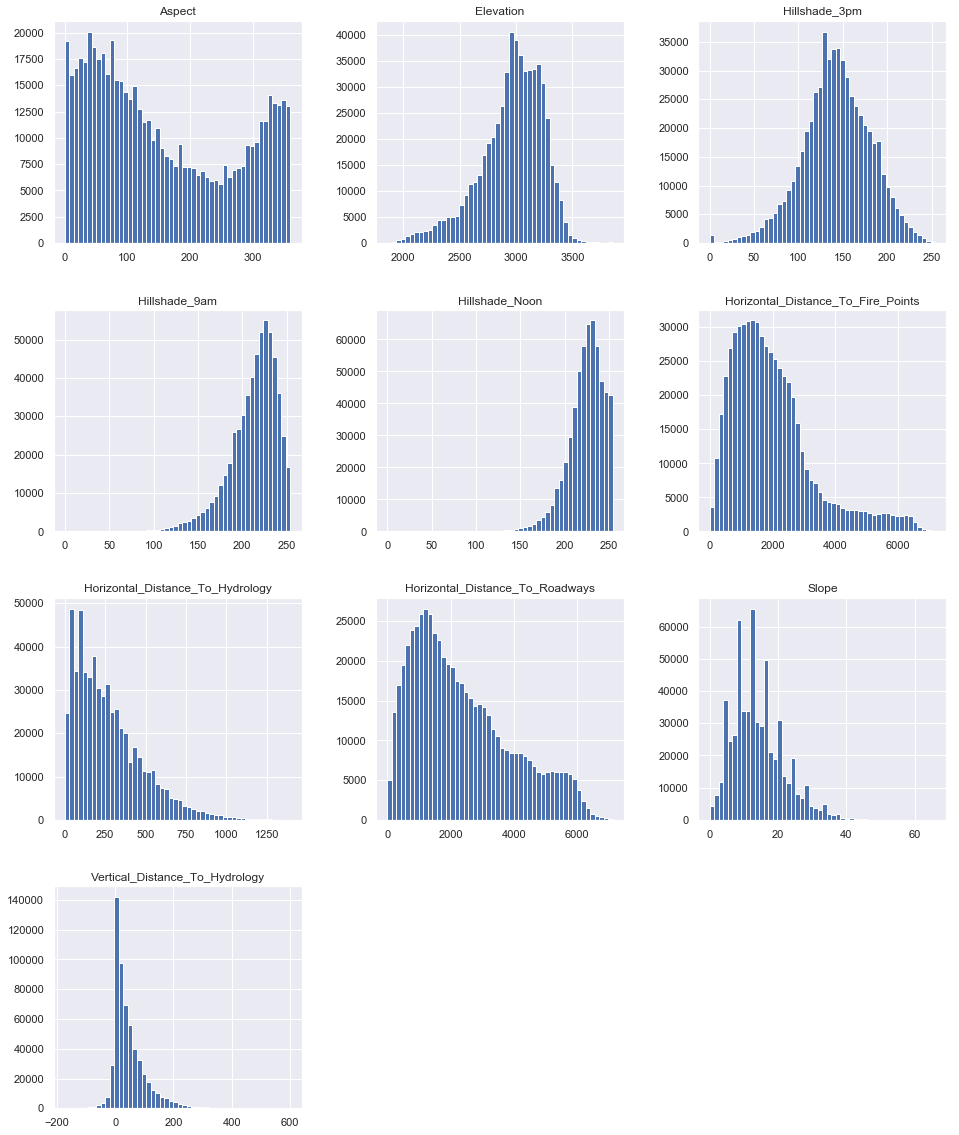

In [48]:
# Extracting columns containing numerical values
numerical = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 
             'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 
             'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']

data[numerical].hist(figsize=(16, 20), bins=50);

There doesn't seem to be clear outliers. Next we can plot target variable distributions.

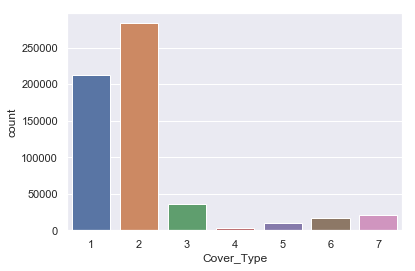

In [54]:
sns.countplot(data.Cover_Type);

### Todo

Study target variable distribution

Try jointplot (scatter + histogram) to find relations between target and numerical features